<font size='10'><h1 align="center"><font color='blue'>iPy oxDNA Examples</font></h1>

<center>
<img src="oxDNA.png">
</center>

<font size='10'><a class="anchor" id="3"></a> <h2 align="center"> <font color='black'>Duplex Melting</font></h2> 

In [ ]:
from umbrella_sampling import ComUmbrellaSampling, MeltingUmbrellaSampling
from oxdna_simulation import SimulationManager, Simulation, Observable
from wham_analysis import collect_coms
import os
import matplotlib.pyplot as plt
from vmmc import *
from collections import Counter
from parameter_search import * 
import numpy as np
from skopt import Optimizer
from skopt.space import Categorical, Space
from scipy.special import logsumexp
from copy import deepcopy
plt.style.use(['science', 'no-latex', 'bright'])

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
wham_dir = os.path.abspath('/scratch/matthew/ipy_oxDNA/src/wham/wham')
n_bins = '200'
tol = '1e-12'
n_boot = '0'
com_list = '8,9,10,11,12,13,14,15'
ref_list = '0,1,2,3,4,5,6,7'
xmin = 0
xmax = 15
n_windows = 50
starting_r0 = 1
steps = 1e6
stiff=5
for us in us_list:
    us.wham_run(wham_dir, xmin, xmax, stiff, n_bins, tol, n_boot)

In [ ]:
path = os.path.abspath('/scratch/mlsample/ipy_oxDNA/ipy_oxdna_examples/duplex_melting/')

system_name = 'multi_system_runs'

condition = ['30C', '52C','70C']

systems = [f'duplex_{temp}_5_new_op' for temp in condition]

file_dirs = [f'{path}/{system_name}' for _ in range(len(systems))]

# temperature = '70C'

com_list = '8,9,10,11,12,13,14,15'
ref_list = '7,6,5,4,3,2,1,0'
xmin = 0
xmax = 15
n_windows = 60
starting_r0 = 1
print_every = 1e4
stiff = 5
obs_filename = 'all_observables.txt'
hb_contact_filename = 'hb_contacts.txt'

pre_eq_steps = 1e6
eq_steps = 5e6
prod_steps = 2e8

particle_indexes = [com_list, ref_list]
hb_contact_observable = [{'idx':particle_indexes, 'name':f'{hb_contact_filename}', 'print_every':int(print_every)}]


pre_equlibration_parameters_list = [{'backend':'CPU','steps':f'{pre_eq_steps}','print_energy_every': f'{pre_eq_steps}',
                           'print_conf_interval':f'{pre_eq_steps}', "CUDA_list": "no",
                           'use_edge': 'false', 'refresh_vel': '1',
                           'fix_diffusion': '0', 'fix_diffusion_every': '1000',
                           'T':f'{temperature}'} for temperature in condition]

equlibration_parameters_list = [{'backend':'CPU','steps':f'{eq_steps}','print_energy_every': f'{eq_steps}',
                           'print_conf_interval':f'{eq_steps}', "CUDA_list": "no",
                           'use_edge': 'false', 'refresh_vel': '1',
                           'fix_diffusion': '0', 'fix_diffusion_every': '1000',
                           'T':f'{temperature}'} for temperature in condition]

production_parameters_list = [{'backend':'CPU', 'steps':f'{prod_steps}','print_energy_every': f'{prod_steps}',
                        'print_conf_interval':f'{prod_steps}', "CUDA_list": "no",
                        'use_edge': 'false', 'refresh_vel': '1',
                        'fix_diffusion': '0', 'fix_diffusion_every': '1000',
                        'T':f'{temperature}'} for temperature in condition]

us_list = [MeltingUmbrellaSampling(file_dir, sys, clean_build='force') for file_dir, sys in zip(file_dirs,systems)]

simulation_manager = SimulationManager()

In [ ]:
for us, pre_equlibration_parameters in zip(us_list, pre_equlibration_parameters_list):
    print(us.system)
    us.build_pre_equlibration_runs(simulation_manager, n_windows, com_list, ref_list,
                               stiff, xmin, xmax, pre_equlibration_parameters, starting_r0, pre_eq_steps,
                               print_every=print_every, observable=True, protein=None, name=obs_filename,
                               force_file=None, continue_run=False, custom_observable=hb_contact_observable)

In [ ]:
simulation_manager.worker_manager(cpu_run=True, gpu_mem_block=False)

In [ ]:
for us, equlibration_parameters in zip(us_list, equlibration_parameters_list):
    print(us.system)
    us.build_equlibration_runs(simulation_manager, n_windows, com_list, ref_list,
                               stiff, xmin, xmax, equlibration_parameters,
                               print_every=print_every, observable=True, protein=None, name=obs_filename,
                               force_file=None, continue_run=False, custom_observable=hb_contact_observable)

In [ ]:
simulation_manager.worker_manager(cpu_run=True, gpu_mem_block=False)

In [ ]:
for us, production_parameters in zip(us_list, production_parameters_list):
    print(us.system)
    us.build_production_runs(simulation_manager, n_windows, com_list, ref_list,
                             stiff, xmin, xmax, production_parameters,
                             observable=True, print_every=print_every ,protein=None, name=obs_filename,
                             force_file=None, continue_run=False, custom_observable=hb_contact_observable)

In [ ]:
simulation_manager.run(cpu_run=True, gpu_mem_block=False)

In [ ]:
simulation_manager.terminate_all()

In [ ]:
for us in us_list:
    us.observables_list = []
    us.com_distance_observable(com_list, ref_list, print_every=print_every, name=obs_filename)
    us.hb_list_observable(print_every=print_every, only_count='true', name=obs_filename)
    us.force_energy_observable(print_every=print_every, name=obs_filename)
    us.kinetic_energy_observable(print_every=print_every, name=obs_filename)
    us.potential_energy_observable(print_every=print_every, name=obs_filename)

# all_observables = []
# for us in us_list:
#     all_observables.append(us.analysis.read_all_observables('prod'))

In [ ]:
names = ['backbone', 'bonded_excluded_volume', 'stacking', 'nonbonded_excluded_volume', 'hydrogen_bonding', 'cross_stacking', 'coaxial_stacking', 'debye_huckel']
columns = ['com_distance', 'hb_list', 'force_energy', *names]


fig, ax = plt.subplots(dpi=300)
for idx, obs in enumerate(us_list[0].obs_df):
    plt.plot(obs['steps'], obs['com_distance'].rolling(window=1000).mean(), label=f'{idx}')
plt.legend(fontsize=1)

In [91]:
temp_range = np.array([30, 52, 70])   
n_bins = 200
xmin = 0
xmax = 15

free, F_i, f_i_time = us_list[1].wham_temperature_interpolation(
    temp_range, n_bins, xmin, xmax,
    epsilon=1e-9, reread_files=False, all_observables=True)

Converged in [41745] iterations


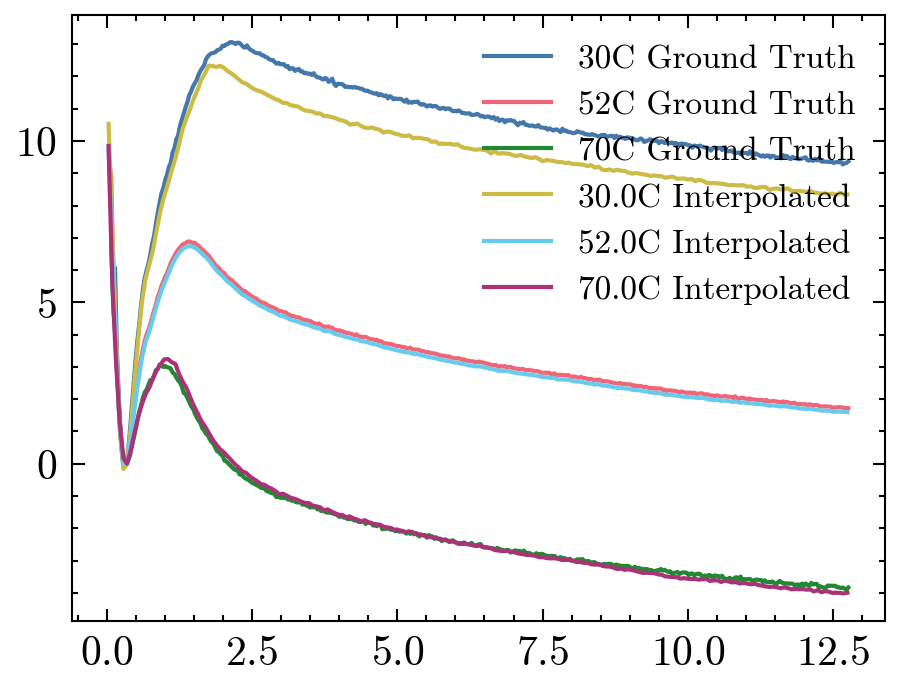

In [92]:
calculated_bin_centers, bin_edges = us_list[0].get_bins(xmin, xmax, n_bins=200)
with plt.style.context(['science', 'no-latex', 'bright']): 

    fig, ax = plt.subplots(dpi=300)
    
    
    for us, temp_val in zip(us_list, temp_range):
        us.wham.plot_free_energy(ax=ax, label=f'{temp_val}C Ground Truth')

        

    for f, temp_val in zip(free, temp_range):
        # f = f / ((temp_val + 273.15) / 3000)
        plt.plot(calculated_bin_centers*0.8518, f - f[5], label=f'{temp_val:.1f}C Interpolated') 
        
plt.legend(fontsize=8)

In [160]:
max_hb = 8
temp_range = np.array([30, 52, 70])   
index_to_add_at = us_list[1].temperature_interpolation(max_hb, temp_range, reread_files=False, all_observables=True)

In [161]:
free = [f - f[0] for f in us_list[1].free_energy_discrete ]
free

[array([ 0.        ,  9.29529825,  7.28002028,  5.53393334,  3.05785737,
         0.73407984, -1.42244202, -2.98373153, -3.62789813], dtype=float128),
 array([0.        , 9.68064901, 9.13242364, 8.09652332, 6.60943859,
        5.1141814 , 3.7691425 , 2.94194675, 2.94583758], dtype=float128),
 array([0.        , 9.64703235, 9.77082841, 9.69479377, 9.43618435,
        9.04497195, 8.62552856, 8.49216672, 8.92985703], dtype=float128)]

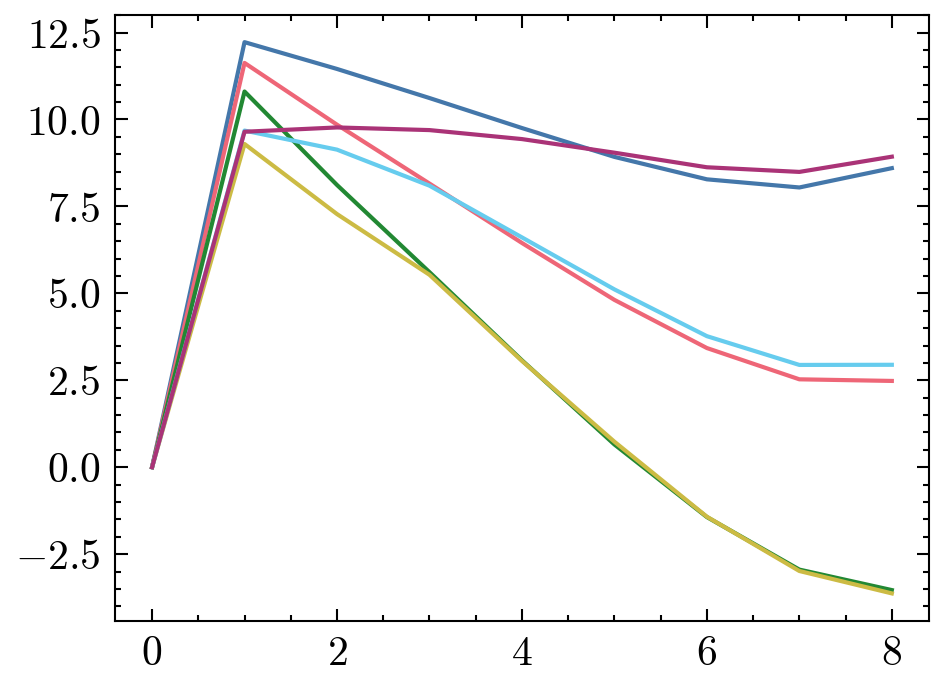

In [162]:
fig, ax = plt.subplots(dpi=300)
ax.plot(range(9), vmmc_replica_generator.sim_list[0].statistics['wt_occ_70.0C_free']- vmmc_replica_generator.sim_list[0].statistics['wt_occ_70.0C_free'][0])

ax.plot(range(9), vmmc_replica_generator.sim_list[0].statistics['wt_occ_52.0C_free']- vmmc_replica_generator.sim_list[0].statistics['wt_occ_52.0C_free'][0])

ax.plot(range(9), vmmc_replica_generator.sim_list[0].statistics['wt_occ_34.0C_free']- vmmc_replica_generator.sim_list[0].statistics['wt_occ_34.0C_free'][0])


for temp, f in zip(temp_range, free):
    ax.plot(range(9), f)

In [164]:
us_list[1].prob_discrete

array([[1.58544047e-02, 1.45630789e-06, 1.09264053e-05, 6.26315599e-05,
        7.44970983e-04, 7.60927210e-03, 6.57519535e-02, 3.13305543e-01,
        5.96658841e-01],
       [8.80106260e-01, 5.49898662e-05, 9.51423592e-05, 2.68077096e-04,
        1.18602106e-03, 5.29022753e-03, 2.03056700e-02, 4.64369694e-02,
        4.62566425e-02],
       [9.99102814e-01, 6.45590701e-05, 5.70418131e-05, 6.15481135e-05,
        7.97126759e-05, 1.17876919e-04, 1.79304308e-04, 2.04884468e-04,
        1.32258182e-04]], dtype=float128)

In [105]:
truncated_force_energy[0] / 16, truncated_umbrella_bias[0]

(array([0.011563, 0.015581, 0.004313, ..., 0.018381, 0.014657, 0.020404]),
 0        0.004928
 1        0.014175
 2        0.002326
 3        0.004951
 4        0.036542
            ...   
 19996    0.066178
 19997    0.008439
 19998    0.022326
 19999    0.011765
 20000    0.028891
 Name: com_distance, Length: 20001, dtype: float64)

In [ ]:
name = 'all_observables.txt'
com_list = '8,9,10,11,12,13,14,15'
ref_list = '7,6,5,4,3,2,1,0'

for us in us_list:
    us.observables_list = []
    us.com_distance_observable(com_list, ref_list, print_every=print_every, name=name)
    us.hb_list_observable(print_every=print_every, only_count='true', name=name)
    us.force_energy_observable(print_every=print_every, name=name)
    us.potential_energy_observable(print_every=print_every, name=name)

wham_dir = os.path.abspath('/scratch/mlsample/ipy_oxDNA/wham/wham')
n_bins = '400'
tol = '1e-12'
n_boot = '0'

xmin = 0
xmax = 15
n_windows = 100
starting_r0 = 1
print_every = 1e4
stiff = 5

for us in us_list:
    us.wham_run(wham_dir, xmin, xmax, stiff, n_bins, tol, n_boot, all_observables=True)
    
n_chunks = 2
data_added_per_iteration = 3

for us in us_list:
    us.wham.get_n_data_per_com_file()
    us.convergence_analysis(n_chunks, data_added_per_iteration, wham_dir, xmin, xmax, stiff, n_bins, tol, n_boot)

In [ ]:
for us in us_list:
    us.wham.plot_truncated_free_energy()
    plt.legend()
    plt.title(us.system)
    us.wham.plot_chunks_free_energy()
    plt.legend()
    plt.title(us.system)

In [ ]:
simulation_manager.terminate_all()

In [ ]:
for us in us_list:
    us.com_distance_observable(com_list, ref_list)


for us in us_list:
    plt.figure(dpi=200)
    for idx in range(0,50,1):
        us.analysis.view_observable('prod', idx, observable=us.observables_list[0], sliding_window=100)
    # plt.legend([us.system], fontsize=7)

In [144]:
path = os.path.abspath('/scratch/mlsample/ipy_oxDNA/ipy_oxdna_examples')
systems = ['duplex_melting']

file_dir_list = [f'{path}/{sys}' for sys in systems]
sim_dir_list = [f'{file_dir}/vmmc_melting_replicas/vmmc_melting_rep' for sys, file_dir in zip(systems, file_dir_list)]

n_replicas = 40
vmmc_replica_generator = VmmcReplicas()

vmmc_replica_generator.multisystem_replica(
    systems,
    n_replicas,
    file_dir_list,
    sim_dir_list
)
vmmc_sim_list = vmmc_replica_generator.sim_list
queue_of_simulations = vmmc_replica_generator.queue_of_sims

/home/mlsample/.local/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/mlsample/.local/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


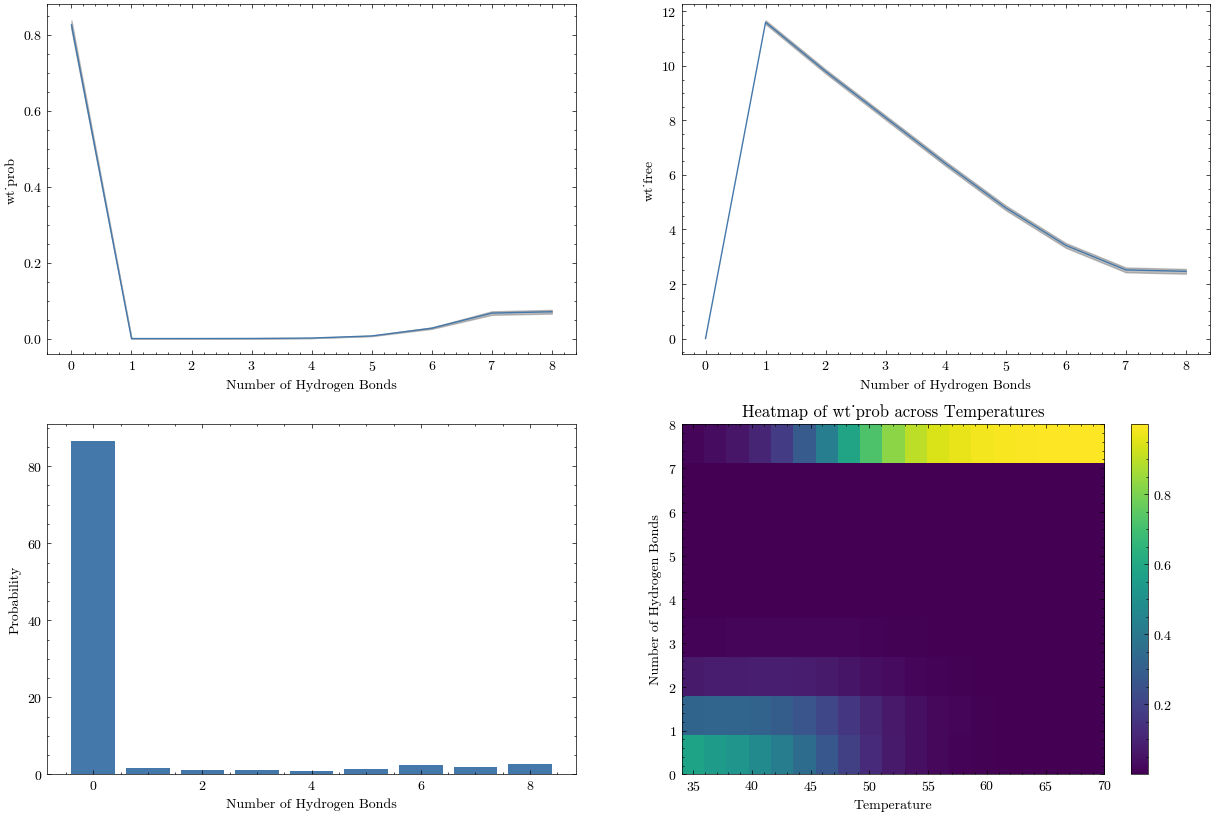

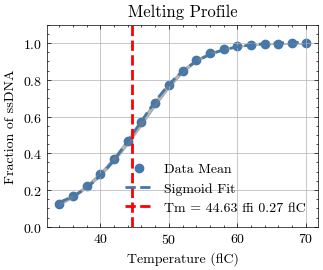

In [145]:
vmmc_replica_generator.statistical_analysis_and_plot()

In [ ]:
fig, ax = plt.subplots()

vmmc_replica_generator.plot_mean_free_energy_with_error_bars(num_bins=1000, errorevery=20,ax=ax)
for us in us_list:
    us.wham.plot_free_energy(ax = ax)
plt.legend()
plt.xlim(-0.1, 3)
plt.ylim(-0.1,8.1)

In [ ]:
max_hb = 8
temp_range = np.array([25, 30, 35, 40, 45, 50, 52, 55, 60, 65, 70])   
us_list[0].temperature_interpolation(max_hb, temp_range, reread_files=False)

In [ ]:
for free in us_list[0].free_energy_discrete:
    plt.plot(range(9), free - free[0])
    
# plt.plot(range(9), vmmc_replica_generator.sim_list[0].statistics['wt_occ_34.0C_free'] - vmmc_replica_generator.sim_list[0].statistics['wt_occ_34.0C_free'][0])

# plt.plot(range(9), vmmc_replica_generator.sim_list[0].statistics['wt_occ_70.0C_free']- vmmc_replica_generator.sim_list[0].statistics['wt_occ_70.0C_free'][0])

# plt.plot(range(9), vmmc_replica_generator.sim_list[0].statistics['wt_occ_52.0C_free']- vmmc_replica_generator.sim_list[0].statistics['wt_occ_52.0C_free'][0])

# plt.plot(range(9), vmmc_replica_generator.sim_list[0].statistics['wt_occ_34.0C_free'])

In [ ]:
bound_states, unbound_states = us_list[0].calculate_melting_temperature()


In [ ]:
us_list[0].prob_discrete.shape

In [ ]:
max_hb = 8
us_list[0].continuous_to_discrete_unbiasing(max_hb)

# Scale A_i with diffrent beta values and recompute temps

In [ ]:
temp_range = np.array([25, 30, 35, 40, 45, 50, 52, 55, 60, 65, 70])   
n_bins = 200
free, F_i_temps, f_i_temps_over_time = us_list[0].wham_temperature_interpolation(temp_range, n_bins)

In [ ]:
temp_range = np.array([30, 52, 70])   
min_length = min([len(inner_list) for inner_list in us_list[0].umbrella_bias])
umbrella_bias = np.array([inner_list[:min_length] for inner_list in us_list[0].umbrella_bias]).squeeze(-1)
potential_energy = [inner_list[:min_length] for inner_list in us_list[0].potential_energy_by_window.values()]

energy_bias_per_window_per_temperature = np.array(us_list[0]._calculate_energy_bias(temp_range, truncated_potential_energy=potential_energy))

new_energy_bias_per_window_per_temperature = np.array(us_list[0]._new_calcualte_bias_energy(umbrella_bias, temp_range, truncated_potential_energy=potential_energy))


In [ ]:
new_energy_bias_per_window_per_temperature

In [ ]:
energy_bias_per_window_per_temperature - new_energy_bias_per_window_per_temperature

In [ ]:
potential_energy = [inner_list[:min_length] for inner_list in us_list[0].potential_energy_by_window.values()]

potential_energy_sum = [pot_energy.sum(axis=1) for pot_energy in potential_energy]

In [ ]:
potential_energy[6]

In [ ]:
energy = [inner_list[:min_length] for inner_list in us_list[0].energy_by_window.values()]
kinetic_energy = np.array([ene['K'] for ene in energy])
energy[6]

In [ ]:
with_kinetic_energy = np.array(us_list[0]._new_calcualte_bias_energy(kinetic_energy, temp_range, truncated_potential_energy=potential_energy))


In [ ]:
with_kinetic_energy - new_energy_bias_per_window_per_temperature

In [ ]:
temp_range = np.array([30, 52, 70])   
n_bins = 200
free_kinetic, F_i_temps_kinetic, f_i_temps_over_time_kinetic = us_list[0].wham_temperature_interpolation(temp_range, n_bins)

In [ ]:
kinetic_energy_and_umbrella_bias = umbrella_bias + kinetic_energy
with_kinetic_energy_umbrella_bias = np.array(us_list[0]._new_calcualte_bias_energy(kinetic_energy_and_umbrella_bias, temp_range, truncated_potential_energy=potential_energy))


In [ ]:
with_kinetic_energy_umbrella_bias - with_kinetic_energy

In [ ]:
temp_range = np.array([30, 52, 70])   
n_bins = 200
free_kinetic_bias, F_i_temps_kinetic_bias, f_i_temps_over_time_kinetic_bias = us_list[0].wham_temperature_interpolation(temp_range, n_bins)

In [ ]:
temp_range = np.array([30, 52, 70])   
n_bins = 200
free_kinetic_bias_w_beta, F_i_temps_kinetic_bias_w_beta, f_i_temps_over_time_kinetic_bias_w_beta = us_list[0].wham_temperature_interpolation(temp_range, n_bins)

In [ ]:
temp_range = np.array([25, 30, 35, 40, 45, 50, 52, 55, 60, 65, 70])   
n_bins = 200
free_kinetic_bias_new_w_beta, F_i_temps_kinetic_bias_new_w_beta, f_i_temps_over_time_kinetic_bias_new_w_beta = us_list[0].wham_temperature_interpolation(temp_range, n_bins)

In [ ]:
xmin = 0
xmax = 15
calculated_bin_centers, bin_edges = us_list[0].get_bins(xmin, xmax, n_bins=200)
temp = [us_list_ground_truth[1], us_list_ground_truth[-1]]
with plt.style.context(['science', 'no-latex', 'bright']): 

    fig, ax = plt.subplots(dpi=300)
    
    # us_list[0].wham.plot_free_energy(ax=ax, label='duplex_52')
    
    # for us in temp:
    #     us.free['Free'] -= us.free['Free'][5]
    #     us.wham.plot_free_energy(ax=ax)
        

    for f, temp_val in zip(free_kinetic_bias_new_w_beta, temp_range):
        plt.plot(calculated_bin_centers*0.8518, f - f[5], label=f'{temp_val:.1f}C') 
        
    plt.legend(fontsize=6)

In [ ]:
xmin = 0
xmax = 15
calculated_bin_centers, bin_edges = us_list[0].get_bins(xmin, xmax, n_bins=200)
temp = [us_list_ground_truth[1], us_list_ground_truth[-1]]
with plt.style.context(['science', 'no-latex', 'bright']): 

    fig, ax = plt.subplots(dpi=300)
    
    us_list[0].wham.plot_free_energy(ax=ax, label='duplex_52')
    
    for us in temp:
        us.free['Free'] -= us.free['Free'][5]
        us.wham.plot_free_energy(ax=ax)
        

    for f, temp_val in zip(free_kinetic_bias_w_beta, temp_range):
        # f = f / ((temp_val + 273.15) / 3000)
        plt.plot(calculated_bin_centers*0.8518, f - f[5], label=f'{temp_val:.1f}C') 
        
    plt.legend(fontsize=6)

In [ ]:
xmin = 0
xmax = 15
calculated_bin_centers, bin_edges = us_list[0].get_bins(xmin, xmax, n_bins=200)
temp = [us_list_ground_truth[1], us_list_ground_truth[-1]]
with plt.style.context(['science', 'no-latex', 'bright']): 

    fig, ax = plt.subplots(dpi=300)
    
    us_list[0].wham.plot_free_energy(ax=ax, label='duplex_52')
    
    for us in temp:
        us.free['Free'] -= us.free['Free'][5]
        us.wham.plot_free_energy(ax=ax)
        

    for f, temp_val in zip(free_kinetic_bias, temp_range):
        # f = f / ((temp_val + 273.15) / 3000)
        plt.plot(calculated_bin_centers*0.8518, f - f[5], label=f'{temp_val:.1f}C') 
        
    plt.legend(fontsize=6)

In [ ]:
xmin = 0
xmax = 15
calculated_bin_centers, bin_edges = us_list[0].get_bins(xmin, xmax, n_bins=200)
temp = [us_list_ground_truth[1], us_list_ground_truth[-1]]
with plt.style.context(['science', 'no-latex', 'bright']): 

    fig, ax = plt.subplots(dpi=300)
    
    us_list[0].wham.plot_free_energy(ax=ax, label='duplex_52')
    
    for us in temp:
        us.free['Free'] -= us.free['Free'][5]
        us.wham.plot_free_energy(ax=ax)
        

    for f, temp_val in zip(free_kinetic, temp_range):
        plt.plot(calculated_bin_centers*0.8518, f - f[5], label=f'{temp_val:.1f}C') 
        
    plt.legend(fontsize=6)

In [ ]:
np.array(us_list[0].umbrella_bias) /8 * 2

In [ ]:
xmin = 0
xmax = 15
calculated_bin_centers, bin_edges = us_list[0].get_bins(xmin, xmax, n_bins=200)
temp = [us_list_ground_truth[1], us_list_ground_truth[-1]]
with plt.style.context(['science', 'no-latex', 'bright']): 

    fig, ax = plt.subplots(dpi=300)
    
    us_list[0].wham.plot_free_energy(ax=ax, label='duplex_52')
    
    for us in temp:
        us.free['Free'] -= us.free['Free'][5]
        us.wham.plot_free_energy(ax=ax)
        

    for f, temp_val in zip(free, temp_range):
        plt.plot(calculated_bin_centers*0.8518, f - f[5], label=f'{temp_val:.1f}C') 
        
    plt.legend(fontsize=6)

In [ ]:
plt.plot(range(len(f_i_temps_over_time)) ,np.array(f_i_temps_over_time))

In [ ]:
path = os.path.abspath('/scratch/mlsample/ipy_oxDNA/ipy_oxdna_examples/duplex_melting/')

system_name = 'multi_system_runs/temp_set'

systems = ['duplex_25', 'duplex_30', 'duplex_35', 'duplex_40', 'duplex_45', 'duplex_50', 'duplex_55', 'duplex_60', 'duplex_65', 'duplex_70']
temperature_list = [25, 30, 35, 40, 45, 50, 55, 60, 65, 70]

file_dirs = [f'{path}/{system_name}' for _ in range(len(systems))]


com_list = '8,9,10,11,12,13,14,15'
ref_list = '0,1,2,3,4,5,6,7'
xmin = 0
xmax = 15
n_windows = 100

stiff = 0.4

equlibration_parameters_list = [{'backend':'CPU','steps':'5e7','print_energy_every': '4e7',
                           'print_conf_interval':'4e7', "CUDA_list": "no",
                           'use_edge': 'false', 'refresh_vel': '1',
                           'fix_diffusion': '0', 'fix_diffusion_every': '1000',
                           'T':f'{temp}C'} for temp in temperature_list]

production_parameters_list = [{'backend':'CPU','steps':'1e9','print_energy_every': '1e8',
                        'print_conf_interval':'1e8', "CUDA_list": "no",
                        'use_edge': 'false', 'refresh_vel': '1',
                        'fix_diffusion': '0', 'fix_diffusion_every': '1000',
                        'T':f'{temp}C'} for temp in temperature_list]

us_list_ground_truth = [MeltingUmbrellaSampling(file_dir, sys, clean_build='force') for file_dir, sys in zip(file_dirs,systems)]

simulation_manager = SimulationManager()

In [ ]:
with plt.style.context(['science', 'no-latex', 'bright']): 

    fig, ax = plt.subplots(dpi=300)
    for us in us_list_ground_truth[6:7]:
        us.free['Free'] -= us.free['Free'][5]
        us.wham.plot_free_energy(ax=ax)

    for f, temp_val in zip(free[5:6], temp_range[6:7]):
        plt.plot(calculated_bin_centers*0.8518, f - f[5], label=f'{temp_val:.1f}C') 
        
    plt.legend()

In [ ]:
bins = np.linspace(us_list[0].wham.xmin, us_list[0].wham.xmax, 200)
real_bins = np.zeros(len(bins))
for i in range(len(bins)):
    real_bins[i] = us_list[0].wham.xmin + (bins[1] - bins[0])* (i +0.5)

In [ ]:
n_bins = 200
BIN_WIDTH = (us_list[0].wham.xmax - us_list[0].wham.xmin) / n_bins;
BIN_WIDTH

In [ ]:
def potential(bins, r0_value, k):
    return 0.5 * k * (bins - r0_value)**2

beta = 1 / temperature
p
bins = np.linspace(0.037500, 14.962500, 200)
r0 = np.linspace(0, 15, 61)[1:]
window_potentials = np.array([potential(bins, r0_val, 5) for r0_val in r0])
com_values = np.array(list(us_list[0].com_by_window.values())).squeeze(-1)
p_x = us_list[0].free['Prob'].values

p_x_u = p_x * np.exp(-window_potentials * beta)

f_i_manual = -temperature * np.log(np.sum(p_x_u, axis=1))
f_i_manual -= f_i_manual[0]
f_i_manual

# def compute_f_i():
    

In [ ]:
temp_range_scaled = (temp_range + 273.15) / 3000
temperature = np.array(us_list[0].temperature, dtype=np.longdouble)
beta = 1 / temperature
beta_range = 1 / temp_range_scaled

f_i = us_list[0].get_biases()
weight = -beta * np.array(f_i)
weight_norm = logsumexp(weight)
A_i = weight - weight_norm

weight_temps = -beta_range[:, np.newaxis] * np.array(f_i)
weight_temps_norm = logsumexp(weight_temps, axis=1)
A_i_temps = weight_temps - weight_temps_norm[:, np.newaxis]

log_p_i_h = us_list[0].log_p_i_h

a_log_p_i_h = log_p_i_h.T + A_i_temps[:, :]



combine_log_p_i_h = logsumexp(a_log_p_i_h, axis=2)

free_energy = -combine_log_p_i_h.T
free_energy -= free_energy.min(axis=1, keepdims=True)
free_energy[:,0] = free_energy[:,0] - us_list[0].volume_correction
free_energy_discrete = free_energy + us_list[0].volume_correction
normed_free_energy = -free_energy - logsumexp(-free_energy, axis=1, keepdims=True)
prob_discrete = np.exp(normed_free_energy)
prob_discrete

In [ ]:
for free in us_list[0].prob_discrete:
    print(free[0])

In [ ]:
for idx, free in enumerate(us_list[0].free_energy_discrete):
    plt.plot(range(9), free, label=f'{temp_range[idx]}C')
plt.legend()

In [ ]:
plt.plot(range(9), vmmc_replica_generator.sim_list[0].statistics['wt_occ_34.0C_free'] - vmmc_replica_generator.sim_list[0].statistics['wt_occ_34.0C_free'][0])

plt.plot(range(9), vmmc_replica_generator.sim_list[0].statistics['wt_occ_70.0C_free']- vmmc_replica_generator.sim_list[0].statistics['wt_occ_70.0C_free'][0])

plt.plot(range(9), vmmc_replica_generator.sim_list[0].statistics['wt_occ_34.0C_free'])

plt.plot(range(9), vmmc_replica_generator.sim_list[0].statistics['wt_occ_34.0C_free'])

In [ ]:
wham_dir = os.path.abspath('/scratch/mlsample/ipy_oxDNA/wham/wham')
n_bins = '200'
tol = '1e-12'
n_boot = '0'
for us in us_list:
    us.wham_run(wham_dir, xmin, xmax, 10, n_bins, tol, n_boot)

In [ ]:
max_hb = 8
us_list[0].continuous_to_discrete_unbiasing(max_hb)
# us_list[1].continuous_to_discrete_unbiasing(max_hb)

In [ ]:
us_list[0].volume_correction

In [ ]:
fig, ax = plt.subplots(dpi=300)

# ax.plot(range(9), us_list[1].free_energy_discrete, label='us_1')

ax.plot(range(9), us_list[0].free_energy_discrete, label='us_0')
ax.plot(range(9), vmmc_replica_generator.wt_free_mean, label='vmmc')
plt.legend()

In [ ]:
path = os.path.abspath('/scratch/matthew/ipy_oxDNA/ipy_oxdna_examples/duplex_melting/')

system_name = 'multi_system_runs'

systems = ['duplex_25', 'duplex_30', 'duplex_35', 'duplex_40', 'duplex_45', 'duplex_50', 'duplex_55', 'duplex_60', 'duplex_65', 'duplex_70']
temperature_list = [25, 30, 35, 40, 45, 50, 55, 60, 65, 70]

file_dirs = [f'{path}/{system_name}' for _ in range(len(systems))]


com_list = '8,9,10,11,12,13,14,15'
ref_list = '0,1,2,3,4,5,6,7'
xmin = 0
xmax = 15
n_windows = 100

stiff = 0.4

equlibration_parameters_list = [{'backend':'CPU','steps':'5e7','print_energy_every': '4e7',
                           'print_conf_interval':'4e7', "CUDA_list": "no",
                           'use_edge': 'false', 'refresh_vel': '1',
                           'fix_diffusion': '0', 'fix_diffusion_every': '1000',
                           'T':f'{temp}C'} for temp in temperature_list]

production_parameters_list = [{'backend':'CPU','steps':'1e9','print_energy_every': '1e8',
                        'print_conf_interval':'1e8', "CUDA_list": "no",
                        'use_edge': 'false', 'refresh_vel': '1',
                        'fix_diffusion': '0', 'fix_diffusion_every': '1000',
                        'T':f'{temp}C'} for temp in temperature_list]

us_list = [MeltingUmbrellaSampling(file_dir, sys, clean_build='force') for file_dir, sys in zip(file_dirs,systems)]

simulation_manager = SimulationManager()

In [ ]:
wham_dir = os.path.abspath('/scratch/mlsample/ipy_oxDNA/wham/wham')
n_bins = '200'
tol = '1e-12'
n_boot = '0'

xmin = 0
xmax = 15
n_windows = 100
stiff = 0.4
for us in us_list:
    us.spawn_wham_run(wham_dir, xmin, xmax, stiff, n_bins, tol, n_boot, join=False)

In [ ]:
for us in us_list:
    us.free['Free'] -= us.free['Free'][4] 

In [ ]:
fig, ax = plt.subplots(dpi=300)

for us in us_list:
    us.wham.plot_free_energy(ax=ax, label=us.system)

In [ ]:
max_hb = 8
for us in us_list:
    us.continuous_to_discrete_unbiasing(max_hb)

In [ ]:
bound = []
for us in us_list:
    bound.append((us.prob_discrete[0]))

bound

In [ ]:
def sigmoid(self, x, L, x0, k, b):
    return L / (1 + np.exp(-k * (x - x0))) + b

temps = np.linspace(25,70,10)
p0 = [max(bound), np.median(temps), 1, min(bound), 1]  # initial guesses for L, x0, k, b
popt, _ = curve_fit(sigmoid, temps, bound, p0, method='dogbox')
# Generate fitted data
x_fit = np.linspace(min(temps), max(temps), 500)
y_fit = sigmoid(x_fit, *popt)


idx = np.argmin(np.abs(y_fit - 0.5))
Tm = x_fit[idx]

y_fit

In [ ]:
y_fit

In [ ]:
plt.plot(x_fit, y_fit, label='fit')

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(temps, self.inverted_finfs, marker='o', label=f'{label}Data')
plt.plot(self.x_fit, self.y_fit, linestyle='--', linewidth=2, label=f'{label}Sigmoid Fit')

# Add a vertical line at the melting temperature
plt.axvline(x=self.sim.Tm, color='r', linestyle='--', linewidth=2, label=f'{label}Tm = {self.sim.Tm:.2f} °C')

plt.xlabel('Temperature (°C)')
plt.ylabel('Fraction of ssDNA')
plt.title(f'Melting Profile')

# Set y-axis limits
plt.ylim(0, 1.1)

plt.legend()
plt.grid(True)

In [ ]:
for us in us_list[:-3]:
    plt.plot(range(9), us.free_energy_discrete, label=us.system)
plt.legend()

In [ ]:
for us in us_list:
    us.calculate_melting_temperature()

In [ ]:
for us in us_list:
    print(us.inverted_finf)

In [ ]:
temps = np.linspace(25,70,10)
vmmc_replica_generator.sim_list[0].analysis.plot_melting_profiles()
plt.plot(temps,bound)

In [ ]:
for us in us_list:
    us.calculate_melting_temperature_using_vmmc()

In [ ]:
inverted_finfs = []
temperatures = []
for us in us_list:
    inverted_finfs.append(1 - us.vmmc_sim.analysis.finfs[0])
    temperatures.append(float((us.system.split('_')[-1])))
# del inverted_finfs[2]
# del temperatures[2]
inverted_finfs

In [ ]:
def sigmoid(x, L, x0, k, b):
    return L / (1 + np.exp(-k * (x - x0))) + b

from scipy.optimize import curve_fit

p0 = [max(inverted_finfs), np.median(temperatures), 1, min(inverted_finfs)]  # initial guesses for L, x0, k, b
popt, _ = curve_fit(sigmoid, temperatures, inverted_finfs, p0, method='dogbox')

x_fit = np.linspace(min(temperatures), max(temperatures), 500)
y_fit = sigmoid(x_fit, *popt)

idx = np.argmin(np.abs(y_fit - 0.5))
Tm = x_fit[idx]

In [ ]:
# Plotting
# plt.figure(figsize=(10, 6))
vmmc_sim_list[0].analysis.plot_melting_profiles(label='VMMC Discrete ')

plt.scatter(temperatures, inverted_finfs, marker='o', label='Continous umbrella made discrete data')
plt.plot(x_fit, y_fit, linestyle='--', linewidth=2, label='Continous umbrella made discrete Sigmoid Fit')

# Add a vertical line at the melting temperature
plt.axvline(x=Tm, color='green', linestyle='--', linewidth=2, label=f'Continous umbrella made discrete Tm = {Tm:.2f} °C')

plt.xlabel('Temperature (°C)')
plt.ylabel('Fraction of ssDNA')
plt.title(f'Melting Profile')

# Set y-axis limits
plt.ylim(0, 1.1)

plt.legend()
plt.grid(True)
plt.show()


In [ ]:
us_list[0].get_com_distance_by_window()
us_list[0].get_bias_potential_value(us_list[0].wham.xmin, us_list[0].wham.xmax, us_list[0].n_windows, us_list[0].wham.umbrella_stiff)
us_list[0].get_r0_values()

if us_list[0].potential_energy_by_window is None:
    us_list[0].read_potential_energy()

In [ ]:
def w_i(r, r0, stiff):
    return 0.5 * float(stiff) * (r - r0)**2

def get_bins(xmin, xmax, n_bins=200):
    # Calculate the bin width
    bin_width = (xmax - xmin) / n_bins

    # Calculate the first bin center
    first_bin_center = xmin + bin_width / 2

    # Generate the bin centers
    calculated_bin_centers = np.array([first_bin_center + i * bin_width for i in range(n_bins)])

    # Calculate bin edges based on bin centers
    bin_edges = np.zeros(len(calculated_bin_centers) + 1)
    bin_edges[1:-1] = (calculated_bin_centers[:-1] + calculated_bin_centers[1:]) / 2.0
    bin_edges[0] = calculated_bin_centers[0] - (bin_edges[1] - calculated_bin_centers[0])
    bin_edges[-1] = calculated_bin_centers[-1] + (calculated_bin_centers[-1] - bin_edges[-2])

    return calculated_bin_centers, bin_edges

def celcius_to_scaled(temp):
    return (temp + 273.15) / 3000

def weighted_histogram_analysis_method_temperature_interpolation(temp_range):
    #Get temperature scalar
    temp_range_scaled = celcius_to_scaled(temp_range)
    beta_range = 1 / temp_range_scaled

    temperature = np.array(us_list[0].temperature, dtype=np.longdouble)
    beta = 1 / temperature
    
    umbrella_bias = np.array(us_list[0].umbrella_bias).squeeze(-1)
    new_energy_per_window = us_list[0]._new_calcualte_bias_energy(umbrella_bias, temp_range)
    temp_biases = np.exp(np.array(new_energy_per_window).swapaxes(0,1) * beta_range[:,np.newaxis, np.newaxis])
    #Get the energy bias per window per temperature
    # energy_bias_per_window_per_temperature = np.array(us_list[0]._calculate_energy_bias(temp_range))
    # temp_biases = np.exp(beta_range[:,np.newaxis, np.newaxis] * energy_bias_per_window_per_temperature.swapaxes(0,1) + umbrella_bias_per_temp)
    #Intalise the inital free energy shift
    # F_i_temps = np.array([[np.random.randint(10) for F in us_list[0].get_biases()] for _ in temp_range_scaled])

    #get the bin values
    xmin = 0
    xmax = 15
    calculated_bin_centers, bin_edges = get_bins(xmin, xmax, n_bins=200)

    #Calculate the biases in the windows
    window_biases = np.array([[
        w_i(bin_value, r0_value, us_list[0].wham.umbrella_stiff)
        for bin_value in calculated_bin_centers
        ] 
        for r0_value in us_list[0].r0
    ], dtype=np.longdouble)

    #Get the com values
    all_com_values = np.array(list(us_list[0].com_by_window.values())).squeeze(-1)

    #Calculate the counts of each bin
    count = [
        [
        np.histogram(com_values, bins=bin_edges, weights=t_bias)[0]
        for com_values, t_bias in zip(all_com_values, temp_bias)
        ] 
        for temp_bias in temp_biases
    ]

    #Put the counts into an array
    p_i_b_s = np.array(count)

    #The numerator of p_x is the sum of the counts from each window
    numerator = np.sum(p_i_b_s, axis=1)
    
    rng = np.random.default_rng()    
    epsilon = 1e-12
    
    f_i_temps_old = np.array([[rng.normal(loc=0.0, scale=1.0, size=None) for F in us_list[0].get_biases()] for _ in temp_range_scaled])
    f_i_temps_new = np.zeros_like(f_i_temps_old)
    f_i_temps_over_time = []
    
    first = True
    while (first is True) or (np.max((f_i_temps_new - f_i_temps_old)**2) > epsilon):
        first = False
        f_i_temps_old = deepcopy(f_i_temps_new)
        
        #Compute the denominator
        denominator = np.array([
            [
            sum(counts) * np.exp((F - w) * bet)

            for counts, F, w, t_bias in zip(p_i_b, F_i, window_biases, temp_b)
            ] 
            for bet, F_i, temp_b, p_i_b in zip(beta_range, f_i_temps_old, temp_biases, p_i_b_s)
        ])

        #Compute the probability of each bin
        p_x = numerator / np.sum(denominator, axis=1)

        #Recompute the f_i values per window. This value will update till convergence
        f_i_bias_factor = np.array([np.exp(-window_biases * bet) for bet in beta_range])
        sum_p_bf = np.sum([p_ * f_ for p_, f_ in zip(p_x, f_i_bias_factor)], axis=2)
        
        f_i_temps_new = -temp_range_scaled[:,np.newaxis] * np.log(sum_p_bf)
    
        f_i_temps_over_time.append((np.max((f_i_temps_new - f_i_temps_old)**2)))
        
    value = f_i_temps_new[:,0]
    F_i_temps = f_i_temps_new - value[:,np.newaxis]

    #Get free energy
    free = -np.log(p_x)
    free = free - np.min(free, axis=1, keepdims=True)
    
    return free, F_i_temps, f_i_temps_over_time
 
temp_range = np.arange(40,46,5)    
free, F_i_temps, f_i_temps_over_time = weighted_histogram_analysis_method_temperature_interpolation(temp_range)